<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Ann Weitz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
variable_column = ["temp", "o3"]
#variable_column = ["temp"]

In [ ]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [ ]:
# Function from Notebook 3, adapted to multivariate data
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, feature_columns, n_past=336, n_future=96):
    df = data.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['station_code', 'datetime']).reset_index(drop=True)

    # 1) Encode station_code as a small integer (categorical codes) to save memory
    df['sc_code'] = df['station_code'].astype('category')

    # 2) Boolean mask: True if exactly 1 hour after the previous row (per station)
    is1h = (
        df.groupby('station_code')['datetime']
          .diff()
          .eq(pd.Timedelta(hours=1))
    )

    # 3) Compute how many consecutive “True” over (n_past + n_future - 1) rows
    gap_window = n_past + n_future - 1
    run = (
        is1h.groupby(df['station_code'])
            .rolling(window=gap_window, min_periods=gap_window)
            .sum()
            .reset_index(level=0, drop=True)
    )

    # 4) 'ends' are indices where run == gap_window (end of a full-length continuous block)
    ends = run[run == gap_window].index

    # 5) Grab column‐arrays for encoded station code and all feature variables
    sc_arr  = df['sc_code'].values
    feature_arr = df[feature_columns].values
    full_input_df = pd.concat([df[['sc_code']], df[feature_columns]], axis=1)
    full_input = full_input_df.values

    X_list = []
    y_list = []
    for end_idx in ends:
        start_idx = end_idx - gap_window
        if start_idx >= 0 and sc_arr[start_idx] == sc_arr[end_idx]:
            block = full_input[start_idx : end_idx + 1]

            X_list.append(block[:n_past])
            y_list.append(block[n_past:])

    if not X_list:
        # No valid windows
        return np.empty((0, n_past, len(feature_columns)+1)), np.empty((0, n_future, len(feature_columns)+1))

    X = np.stack(X_list)  # shape = (num_windows, n_past, len(feature_columns)+1)
    y = np.stack(y_list)  # shape = (num_windows, n_future, len(feature_columns)+1)
    return X, y

In [ ]:
# Mount google drive when working in colab
hasCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if hasCOLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  BASEPATH = '/content/drive/MyDrive'
else:
  BASEPATH = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataframe with normalized data from google drive
dataframe = pd.read_csv("/content/drive/MyDrive/timeseries_data/mv/normalized_data.csv")
print(dataframe.shape)
# Drop duplicates to get rid of duplicate time-stamps
dataframe.drop_duplicates(["datetime", "station_code"], inplace = True)
dataframe.head()

(440867, 6)


,longitude,latitude,station_code,datetime,o3,temp
0,6.093923,50.754704,DENW094,1997-01-01 00:00:00+00:00,-1.687797,-3.626220
1,6.093923,50.754704,DENW094,1997-01-01 01:00:00+00:00,-1.687797,-3.694622
2,6.093923,50.754704,DENW094,1997-01-01 02:00:00+00:00,-1.687797,-3.708302
3,6.093923,50.754704,DENW094,1997-01-01 03:00:00+00:00,-1.687797,-3.804064
4,6.093923,50.754704,DENW094,1997-01-01 04:00:00+00:00,-1.687797,-3.831425


In [ ]:
# Create pickle files the multivariate data
X, y = create_sequences(dataframe,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train_full, X_test_full = X[:train_size], X[train_size:]
y_train_full, y_test_full = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train_full.shape}, y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test_full.shape}, y_test shape: {y_test_full.shape}")

X_train shape: (95970, 336, 3), y_train shape: (95970, 96, 3)
X_test shape: (41131, 336, 3), y_test shape: (41131, 96, 3)


In [ ]:
# Get mean and std for target variable (o3)
target_idx = variable_column.index("o3")
dataframe = pd.read_csv("/content/drive/MyDrive/timeseries_data/mv/raw_data.csv")
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}
print(scaler_stats)

# Drop the dimension containing the station code
X_train = X_train_full[:,:,1:].copy()
X_test = X_test_full[:,:,1:].copy()

# Drop the other variables, that are not the target variable
y_train = y_train_full[:,:,1+target_idx].copy()
y_test = y_test_full[:,:,1+target_idx].copy()

# Reshape to stack both variable dimensions into one
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Convert to floats
X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test  = np.array(y_test,  dtype=np.float32)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

{'temp': {'mean': np.float64(10.656768563895323), 'std': 7.309752136488672}, 'o3': {'mean': np.float64(24.586900674611172), 'std': 14.567449924073065}}
X_train shape: (95970, 672), y_train shape: (95970, 96)
X_test shape: (41131, 672), y_test shape: (41131, 96)


In [ ]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [128, 64, 32, 16]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

In [ ]:
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "mlp_mv.keras")

# Input dimension for first MLP layer
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]


# Build MLP model with 4 dense layers
model = Sequential([
    Input(shape = (input_dim,)),
    Dense(mlp_hidden_units[0], activation=activation_fn)
])

for units in mlp_hidden_units[1:]:
  model.add(Dense(units, activation=activation_fn))

model.add(Dense(output_dim))

model.compile(optimizer = mlp_optim, loss = mlp_loss)
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
)

# Train model
training = model.fit(
    X_train, y_train,
    epochs=mlp_epochs, batch_size=mlp_batch_size,
    validation_split=0.2, verbose=1,
    callbacks=[checkpoint_callback]
)
training_history = training.history

Epoch 1/5
4796/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6967
Epoch 1: val_loss improved from inf to 0.55378, saving model to ./checkpoint/mlp_mv.keras
4799/4799 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 0.6966 - val_loss: 0.5538
Epoch 2/5
4795/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5719
Epoch 2: val_loss did not improve from 0.55378
4799/4799 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.5719 - val_loss: 0.5592
Epoch 3/5
4795/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5334
Epoch 3: val_loss did not improve from 0.55378
4799/4799 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.5334 - val_loss: 0.5693
Epoch 4/5
4795/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5024
Epoch 4: val_loss did not improve from 0.55378
4799/4799 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - loss: 0.5024 - val_loss: 0.6142
Epoch 5/5
4785/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4821
Epoch 5: val_loss did not improve from 0.55378
4799/4799 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.4821 - val_loss:

In [ ]:
# Make predictions with the model for evaluation
y_pred = model.predict(X_test)

# Evaluate the model
evaluate_model(y_test, y_pred)

1286/1286 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
RMSE: 0.7814


np.float64(0.7813874314545415)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


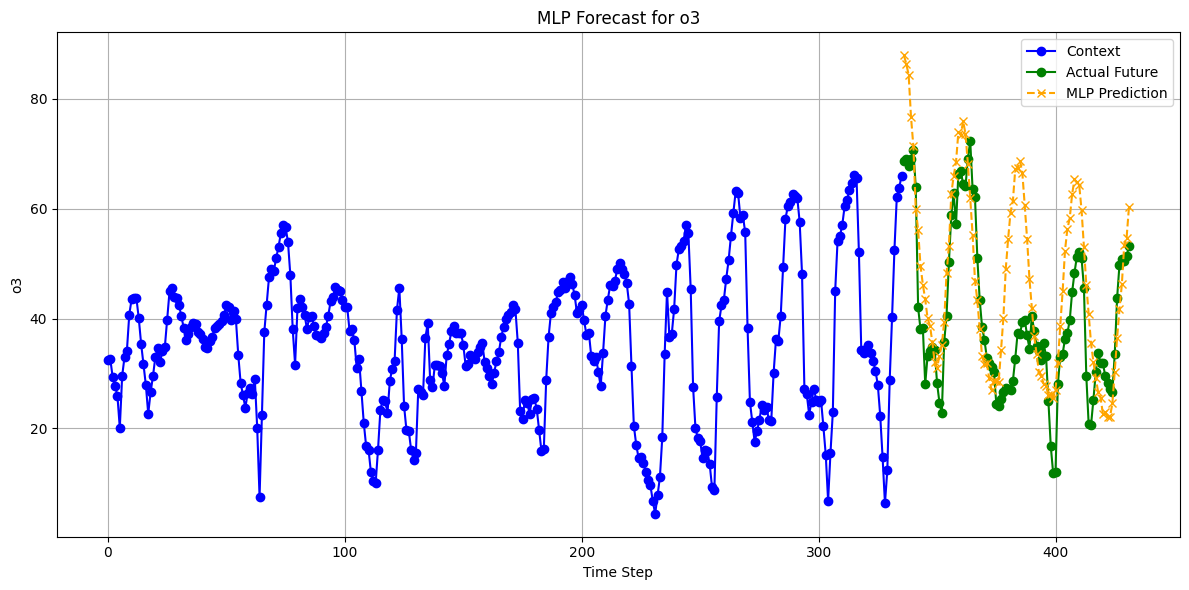

In [ ]:
target_idx = 1
target_var = variable_column[target_idx] # for o3

# Load trained model
mlp_model = load_model(
    os.path.join(checkpoint_dir, f"mlp_mv.keras"),
    custom_objects={"mse": MeanSquaredError()}
)

# Pick a sample from the test data
sample_idx = 42
X_test_sample = X_test[sample_idx]
y_test_sample = y_test[sample_idx]

# Predict
mlp_pred_sample = mlp_model.predict(X_test_sample.reshape(1, -1)).flatten()

# Get context portion (most recent history of the target variable)
X_test_reshaped = X_test_sample.reshape(context_window, len(variable_column))  # shape: (336, 2)
context = X_test_reshaped[:, target_idx]

# Inverse scale
mean = scaler_stats[target_var]['mean']
std = scaler_stats[target_var]['std']

context_scaled = context * std + mean
actual_future = y_test_sample * std + mean
predicted_future = mlp_pred_sample * std + mean

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(context_window), context_scaled, label="Context", color="blue", marker="o")
plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Actual Future", color="green", marker="o")
plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="MLP Prediction", linestyle="--", color="orange", marker="x")

plt.title(f"MLP Forecast for {target_var}")
plt.xlabel("Time Step")
plt.ylabel(target_var)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Save the timeseries and results for visualization and comparison against other models
X_test_sample_df = pd.DataFrame({
    "timestep": range(0,context_window),
    "value": context_scaled
})
y_test_sample_df = pd.DataFrame({
    "timestep": range(context_window, context_window + prediction_horizon),
    "value": actual_future
})

sample_df = pd.concat([X_test_sample_df, y_test_sample_df])
sample_df.to_csv("/content/drive/MyDrive/timeseries_data/mv/sample.csv", index = False)

In [ ]:
mlp_results_mv = pd.DataFrame({
    "timestep": range(context_window, context_window + prediction_horizon),
    "value": predicted_future
})
mlp_results_mv.to_csv("/content/drive/MyDrive/timeseries_data/mv/mlp_results_mv.csv", index = False)

This notebook uses the data generated with 8_Download_Preprocess_data_ozone to generate multivariate training and testing data for timeseries forecasting. After that, we initialize a simple Tensorflow Sequential model for our MLP, with 4 dense hidden layers.

The training uses a checkpoint callback to save the epoch with the lowest validation loss. This being the first epoch and the validation loss increasing afterwards with the training loss still decreasing, already hints at overfitting and probably other problems with the architecture.

After that we make predictions on the test set and calculate the testing loss.

At last, we sample one test datapoint, make predictions with the saved model checkpoint and then plot the context window, actual future and the predicted future from the model.